# Resilient Edge

In [1]:
# automatic reloading of changed modules
%load_ext autoreload
%autoreload 2

In [2]:
import simpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from util import Battery, read_battery_process, solar_charge_process, compute_tasks_process

In [43]:
START_DATE = pd.to_datetime("2021-06-01 00:00:00")
END_DATE = pd.to_datetime("2021-06-08 00:00:00")
INDEX = pd.date_range(START_DATE, END_DATE, freq="s")  # +timedelta(minutes=1)

BATTERY_CAPACITY = 1000  # Wh
BATTERY_INITIAL_SOC = 500  # Wh
SOLAR_AREA = 2  # m^2

# Load data between START_DATE and END_DATE
with open("data/weather_berlin_2021-06.csv", "r") as csvfile:
    weather_df = pd.read_csv(csvfile, parse_dates=True, index_col=0)[START_DATE:END_DATE]
with open("data/low_prio_tasks.csv", "r") as csvfile:
    tasks_df = pd.read_csv(csvfile, parse_dates=True, index_col=0)[START_DATE:END_DATE]
with open("data/high_prio_tasks.csv", "r") as csvfile:
    hptasks_df = pd.read_csv(csvfile, parse_dates=True, index_col=0)[START_DATE:END_DATE]


def plot_battery_soc(battery_socs):
    """Plots the recorded SoC of the battery"""
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(INDEX, battery_socs)
    ax.set_xlabel("seconds")
    ax.set_ylabel("State of Charge (Wh)")
    ax.set_xlim(START_DATE, END_DATE)
    ax.set_ylim(0, BATTERY_CAPACITY)

Text(0, 0.5, 'Solar irradiance (W/m²)')

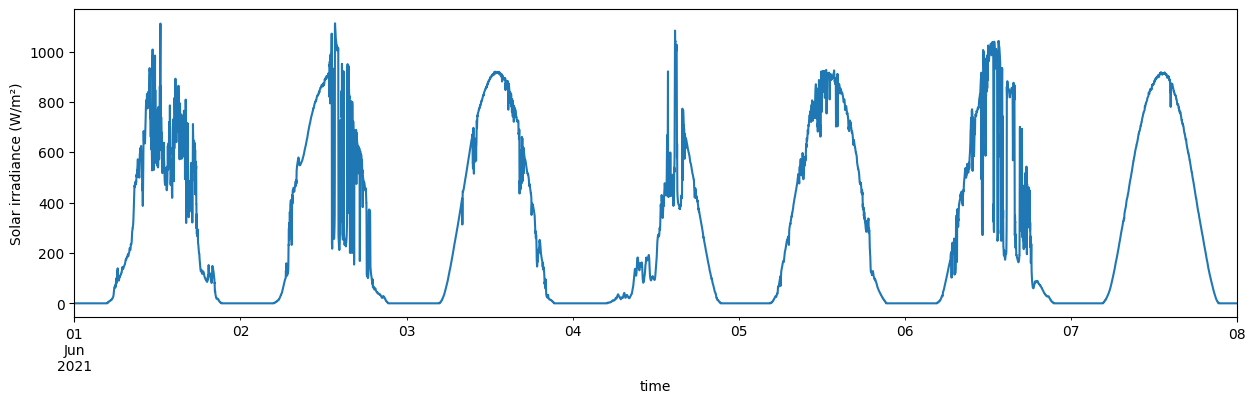

In [44]:
# Plot solar irradiance
fig, ax = plt.subplots(figsize=(15,4))
weather_df["solar"].plot(ax=ax)
# (weather_df["wind"] * 100).plot(ax=ax)
ax.set_ylabel("Solar irradiance (W/m²)")

<AxesSubplot: xlabel='datetime'>

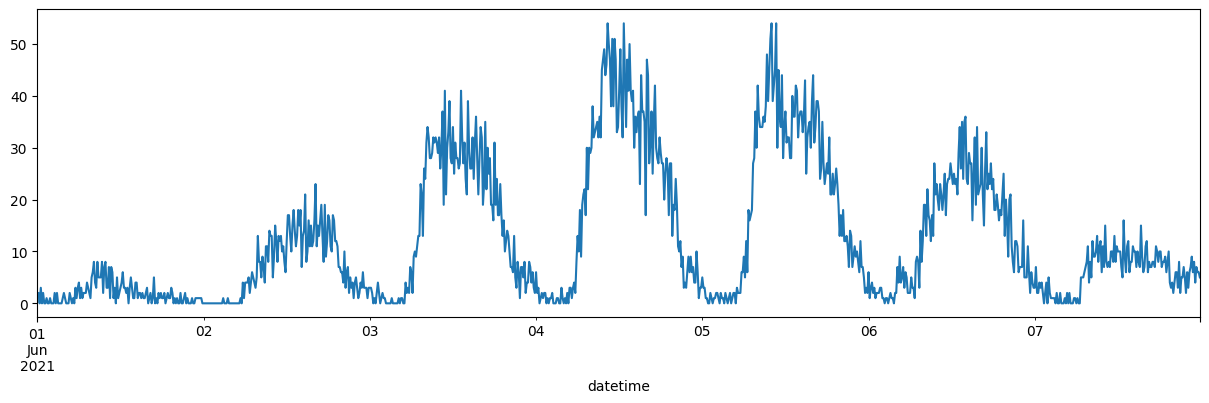

In [45]:
tasks_df["weight"].resample('10min').count().plot(figsize=(15,4))

<AxesSubplot: xlabel='pickup_datetime'>

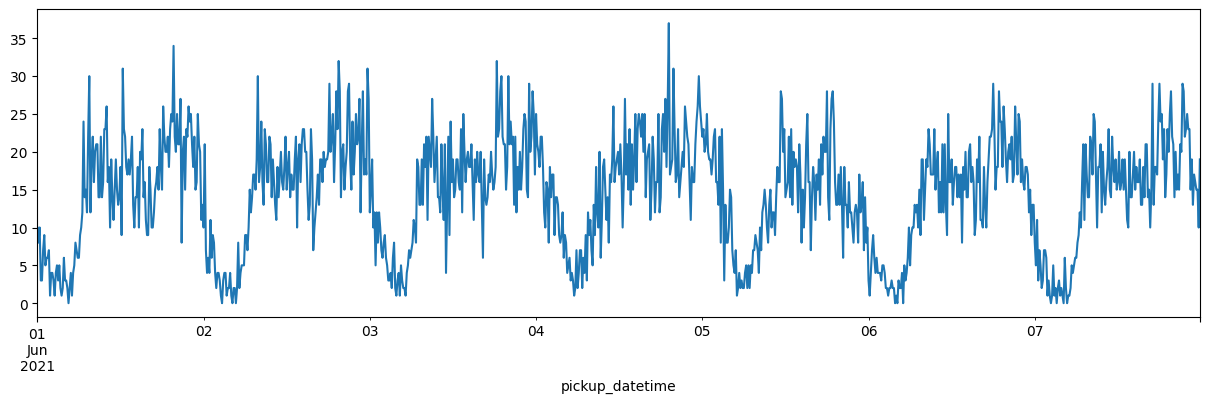

In [46]:
hptasks_df["trip_duration"].resample('10min').count().plot(figsize=(15,4))

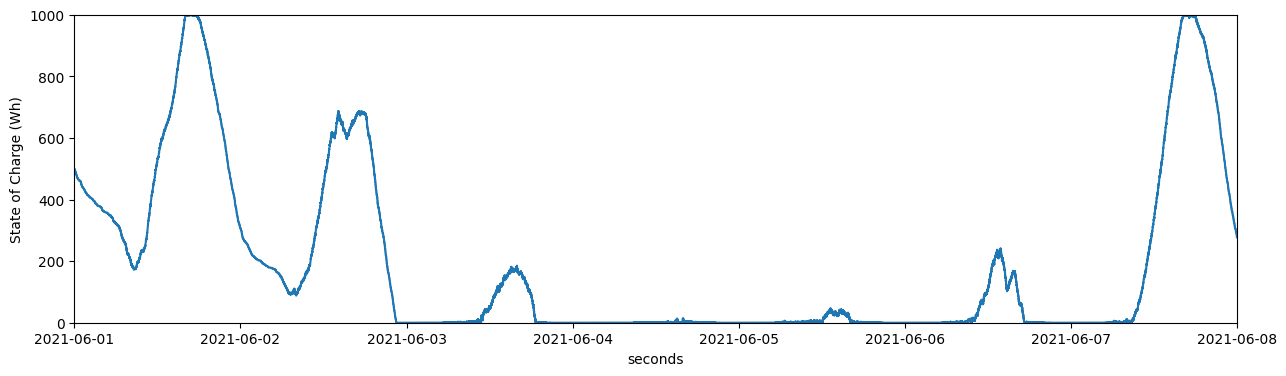

In [50]:
battery = Battery(capacity=BATTERY_CAPACITY, soc=BATTERY_INITIAL_SOC)
battery_socs = []
task_stats = []
hptask_stats = []

env = simpy.Environment()
env.process(solar_charge_process(env, battery, solar_area=SOLAR_AREA, solar_values=weather_df["solar"]))
env.process(compute_tasks_process(env, battery, start_date=START_DATE, task_arrival_times=tasks_df.index, task_stats=task_stats))
env.process(compute_tasks_process(env, battery, start_date=START_DATE, task_arrival_times=hptasks_df.index, task_stats=hptask_stats))
env.process(read_battery_process(env, battery, battery_socs))
env.run(until=len(INDEX))

plot_battery_soc(battery_socs)

<AxesSubplot: >

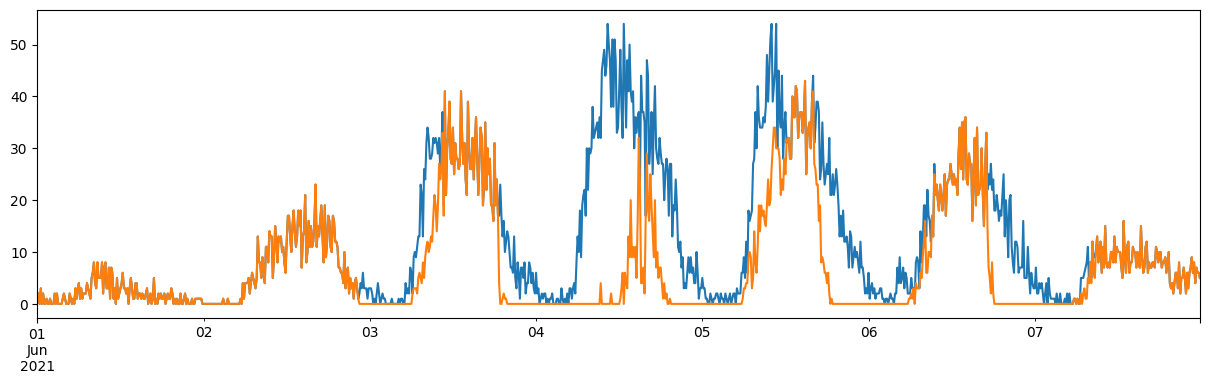

In [51]:
task_stats_index, task_stats_values = zip(*task_stats)
task_stats_series = pd.Series(task_stats_values, index=task_stats_index)
task_stats_series.resample('10min').count().plot(figsize=(15,4))
task_stats_series[task_stats_series].resample('10min').count().plot(figsize=(15,4))

<AxesSubplot: >

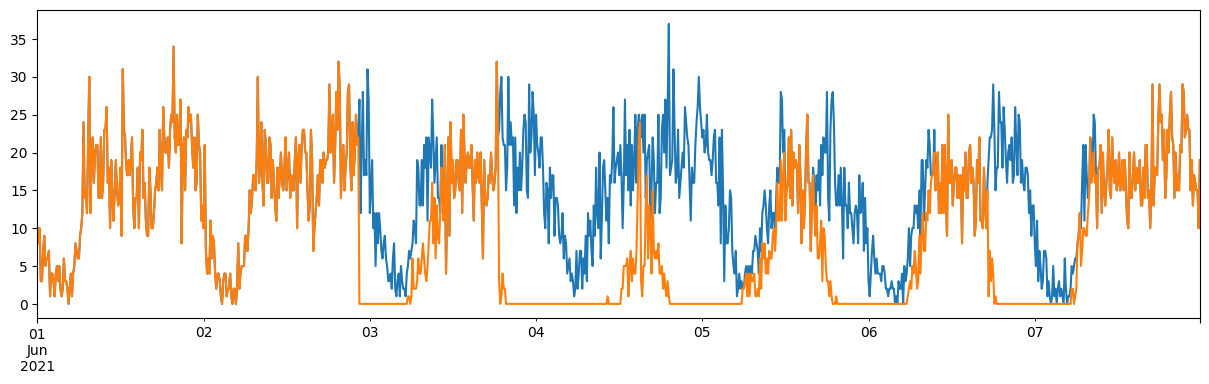

In [52]:
hptask_stats_index, hptask_stats_values = zip(*hptask_stats)
hptask_stats_series = pd.Series(hptask_stats_values, index=hptask_stats_index)
hptask_stats_series.resample('10min').count().plot(figsize=(15,4))
hptask_stats_series[hptask_stats_series].resample('10min').count().plot(figsize=(15,4))